<a href="https://colab.research.google.com/github/cblancovel/GAN_synth/blob/main/TFG_2implementacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Codigo para generar json

In [ ]:
!ls
torch = "some_value"  # This will overwrite the torch module


drive  fitbit_data.json  preprocessed_fitbit_data.csv  sample_data


In [1]:
# %% [code]
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

# Load the dataset (assuming the dataset is in a CSV file)
file_path = "/content/drive/MyDrive/Fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Convert 'ActivityDate' to the required datetime format (YYYY-MM-DD)
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Fill missing values
data.fillna({
    'LoggedActivitiesDistance': 0,
    'VeryActiveDistance': 0,
    'ModeratelyActiveDistance': 0,
    'LightActiveDistance': 0,
    'SedentaryActiveDistance': 0,
    'VeryActiveMinutes': 0,
    'FairlyActiveMinutes': 0,
    'LightlyActiveMinutes': 0,
    'SedentaryMinutes': data['SedentaryMinutes'].mean(),  # Example: fill with mean
    'Calories': data['Calories'].mean()
}, inplace=True)

# Normalize numerical features (scaling them between 0 and 1 for GAN training)
numerical_features = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance',
    'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance',
    'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
    'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'
]

# Encode 'Id' and keep it as the first column
data['Id_encoded'] = data['Id'].astype('category').cat.codes
data = data[['Id_encoded'] + [col for col in data.columns if col != 'Id_encoded']]

# Filter participants to include only the first 21 participants with 31 records
participant_counts = data['Id_encoded'].value_counts()
participants_with_31_records = participant_counts[participant_counts == 31].index[:21]
data = data[data['Id_encoded'].isin(participants_with_31_records)]

# Feature engineering: Add derived features (e.g., day of the week, month) without removing 'ActivityDate'
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'])  # Convert back to datetime for derived features
data['DayOfWeek'] = data['ActivityDate'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['Month'] = data['ActivityDate'].dt.month
data['ActivityDate'] = data['ActivityDate'].dt.strftime('%Y-%m-%d')  # Keep final format as YYYY-MM-DD

# Verify the preprocessed data
print("Processed DataFrame Head:")
print(data.head())

# Save preprocessed data for TimeGAN
preprocessed_file_path = "preprocessed_fitbit_data.csv"
data.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to {preprocessed_file_path}")




# %% [code]
import pandas as pd
import json

# Load the preprocessed CSV
file_path = "preprocessed_fitbit_data.csv"  # Update to your file name
data = pd.read_csv(file_path)

# Initialize the JSON structure
json_data = {}

# Group data by 'Id_encoded' and create JSON structure
for participant_id, group in data.groupby('Id_encoded'):
    # Create a list of dictionaries for this participant's time-series data
    participant_records = group.drop(columns='Id_encoded').to_dict(orient='records')
    # Add to the JSON structure
    json_data[f"participant_{participant_id}"] = participant_records

# Save the JSON to a file
output_json_path = "fitbit_data.json"
with open(output_json_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print(f"Data successfully converted to JSON format and saved to {output_json_path}")


Missing values per column:
Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64
Processed DataFrame Head:
   Id_encoded          Id ActivityDate  TotalSteps  TotalDistance  \
0           0  1503960366   2016-04-12       13162           8.50   
1           0  1503960366   2016-04-13       10735           6.97   
2           0  1503960366   2016-04-14       10460           6.74   
3           0  1503960366   2016-04-15        9762           6.28   
4           0  1503960366   2016-04-16       12669           8.16   

   TrackerDistance  LoggedActivitiesDistance  VeryActiveDistance  \
0

GAN training

Epoch [1/400], Critic Loss: 1.5816, Generator Loss: -0.3362
Epoch [11/400], Critic Loss: 0.0176, Generator Loss: -0.6531
Epoch [21/400], Critic Loss: -0.3842, Generator Loss: -0.3196
Epoch [31/400], Critic Loss: -0.1162, Generator Loss: -1.0722
Epoch [41/400], Critic Loss: 0.0223, Generator Loss: -0.2709
Epoch [51/400], Critic Loss: -0.5636, Generator Loss: 1.1746
Epoch [61/400], Critic Loss: -0.1034, Generator Loss: 0.1391
Epoch [71/400], Critic Loss: 0.4029, Generator Loss: -1.5749
Epoch [81/400], Critic Loss: -0.0366, Generator Loss: -0.7047
Epoch [91/400], Critic Loss: -0.7223, Generator Loss: 0.2856
Epoch [101/400], Critic Loss: -0.4862, Generator Loss: 0.5679
Epoch [111/400], Critic Loss: -0.1284, Generator Loss: -0.4179
Epoch [121/400], Critic Loss: -0.1665, Generator Loss: -0.3924
Epoch [131/400], Critic Loss: -0.1212, Generator Loss: -0.4061
Epoch [141/400], Critic Loss: -0.1613, Generator Loss: -0.4116
Epoch [151/400], Critic Loss: -0.1932, Generator Loss: -0.1225
Epoch [161/

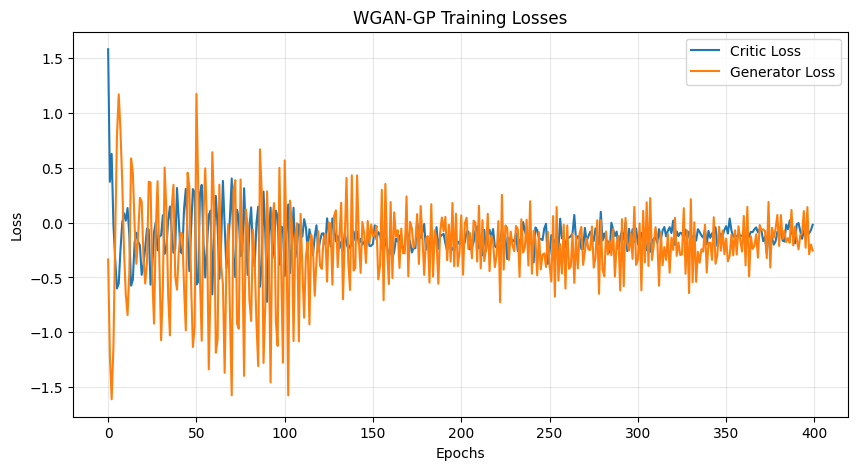

Synthetic data saved to improved_synthetic_fitbit_data.json


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random
import pandas as pd
import json
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = "preprocessed_fitbit_data.csv"
data = pd.read_csv(file_path)

# Extract relevant features
features = [
    "TotalSteps", "TotalDistance", "TrackerDistance", "LoggedActivitiesDistance",
    "VeryActiveDistance", "ModeratelyActiveDistance", "LightActiveDistance",
    "SedentaryActiveDistance", "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "SedentaryMinutes", "Calories", "DayOfWeek", "Month"
]

date_features = ["DayOfWeek", "Month", "ActivityDate"]

data_tensor = torch.tensor(data[features].values, dtype=torch.float32)

# Extract original date-related fields
date_data = data[date_features].drop_duplicates().reset_index(drop=True)
activity_dates = date_data["ActivityDate"].tolist()
day_of_week = date_data["DayOfWeek"].tolist()
month = date_data["Month"].tolist()

# Normalize data to [0, 1]
data_min = data_tensor.min(dim=0)[0]
data_max = data_tensor.max(dim=0)[0]
data_tensor = (data_tensor - data_min) / (data_max - data_min)

# Create DataLoader
batch_size = 128
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic (Discriminator in WGAN-GP)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Gradient Penalty Function
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)  # Match the shape of real_data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.clone().detach().requires_grad_(True)  # Create a leaf tensor with requires_grad

    critic_interpolates = critic(interpolates)
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates, device=real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Hyperparameters
noise_dim = 20
data_dim = len(features)
num_epochs = 400  # Ensure this matches your desired epochs
lr = 0.0002
lambda_gp = 10  # Gradient penalty coefficient
critic_updates = 5  # Number of critic updates per generator update
generator_updates = 2  # Increased generator updates

# Instantiate models
generator = Generator(noise_dim, data_dim)
critic = Critic(data_dim)

# Optimizers
optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

# Initialize lists to store losses
critic_losses = []
generator_losses = []

# Calculate original data mean and variance
original_mean = data_tensor.mean(dim=0)
original_std = data_tensor.std(dim=0)

# Updated Training Loop
for epoch in range(num_epochs):
    for real_data, in data_loader:
        real_data = real_data.to(generator.model[0].weight.device)
        batch_size = real_data.size(0)

        # Train Critic
        for _ in range(critic_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            real_score = critic(real_data)
            fake_score = critic(fake_data.detach())
            gp = gradient_penalty(critic, real_data, fake_data)
            critic_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator (multiple updates per critic step)
        for _ in range(generator_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            gen_loss = -critic(fake_data).mean()
            optim_gen.zero_grad()
            gen_loss.backward()
            optim_gen.step()

    # Log losses once per epoch
    critic_losses.append(critic_loss.item())
    generator_losses.append(gen_loss.item())

    if epoch % 10 == 0:  # Adjust print frequency as needed
        print(f"Epoch [{epoch+1}/{num_epochs}], Critic Loss: {critic_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(critic_losses)), critic_losses, label="Critic Loss")
plt.plot(range(len(generator_losses)), generator_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Losses")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Generate Synthetic Data ---
num_participants = 200
num_days = 31
synthetic_data = []

for participant_id in range(num_participants):
    participant_records = []
    for i, date in enumerate(activity_dates):
        noise = torch.randn(1, noise_dim, device=generator.model[0].weight.device)
        generated = generator(noise).detach().cpu().numpy().flatten()
        generated = generated * (data_max.numpy() - data_min.numpy()) + data_min.numpy()
        generated = np.clip(generated, 0, None)
        record = {
            "Id": participant_id + 1,
            "ActivityDate": date,
            "TotalSteps": int(generated[0]),
            "TotalDistance": float(generated[1]),
            "TrackerDistance": float(generated[2]),
            "LoggedActivitiesDistance": float(generated[3]),
            "VeryActiveDistance": float(generated[4]),
            "ModeratelyActiveDistance": float(generated[5]),
            "LightActiveDistance": float(generated[6]),
            "SedentaryActiveDistance": float(generated[7]),
            "VeryActiveMinutes": float(generated[8]),
            "FairlyActiveMinutes": float(generated[9]),
            "LightlyActiveMinutes": float(generated[10]),
            "SedentaryMinutes": float(generated[11]),
            "Calories": int(generated[12]),
            "DayOfWeek": day_of_week[i % len(day_of_week)],
            "Month": month[i % len(month)],
        }
        participant_records.append(record)
    synthetic_data.append({f"participant_{participant_id}": participant_records})

# Save to JSON
output_json_path = "improved_synthetic_fitbit_data.json"
with open(output_json_path, "w") as json_file:
    json.dump(synthetic_data, json_file, indent=4)

print(f"Synthetic data saved to {output_json_path}")


EVALUATION COMPLETE

Kullback-Leibler Divergence: 11.4583
Jensen-Shannon Divergence: 0.7808
Earth Mover's Distance (EMD): 414.9412
R2 Score: -0.9036
Mean Absolute Error (MAE): 5713.8418
Pearson Correlation Coefficient: 0.0178

Moments Comparison:
Mean - Original: 7927.1167, Synthetic: 7811.8187
Variance - Original: 27270970.9725, Synthetic: 25565853.6384
Skewness - Original: 0.7435, Synthetic: 0.7553
Kurtosis - Original: 1.4757, Synthetic: 0.3529

Original Data KS Test against Normal Distribution
Statistic: 0.0645, p-value: 0.0085

KS Test between Original and Synthetic Data
Statistic: 0.0722, p-value: 0.0672


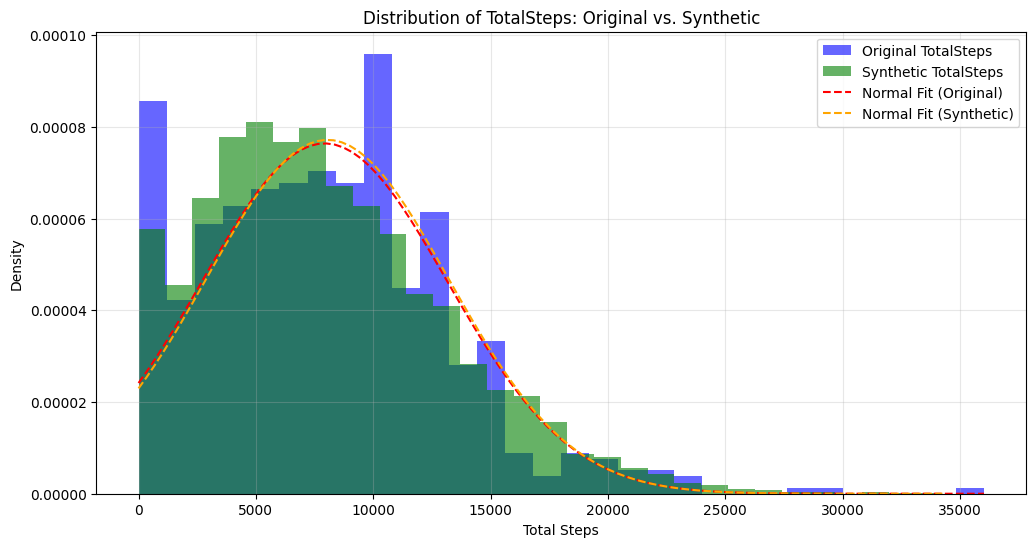

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import random
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# Downsample synthetic data to match original data size
random.seed(42)
synthetic_steps_downsampled = synthetic_steps.sample(n=len(original_steps), random_state=42)

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence with smoothing to avoid `inf`
epsilon = 1e-10
kl_divergence = entropy(original_counts + epsilon, synthetic_counts + epsilon)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")

# --- Additional Metrics ---
# R2 Score
r2 = r2_score(original_steps, synthetic_steps_downsampled)
print(f"R2 Score: {r2:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(original_steps, synthetic_steps_downsampled)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(original_steps, synthetic_steps_downsampled)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps_downsampled)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps_downsampled)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps_downsampled.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps_downsampled.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# Perform KS Test against a normal distribution (original dataset)
std_original = np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("\nOriginal Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic:.4f}, p-value: {ks_test_original.pvalue:.4f}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps_downsampled)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic:.4f}, p-value: {ks_test_comparison.pvalue:.4f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic = np.mean(synthetic_steps)
std_synthetic = np.std(synthetic_steps)

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


GAN not optimized

Epoch [1/400], Critic Loss: -0.1581, Generator Loss: -0.4453
Epoch [11/400], Critic Loss: -0.4216, Generator Loss: 0.2515
Epoch [21/400], Critic Loss: -0.3709, Generator Loss: 0.4155
Epoch [31/400], Critic Loss: 0.0091, Generator Loss: -0.1091
Epoch [41/400], Critic Loss: -0.1052, Generator Loss: 0.3383
Epoch [51/400], Critic Loss: -0.1748, Generator Loss: 0.1792
Epoch [61/400], Critic Loss: -0.1029, Generator Loss: 0.7816
Epoch [71/400], Critic Loss: -0.1245, Generator Loss: 1.0343
Epoch [81/400], Critic Loss: -0.1657, Generator Loss: 0.6881
Epoch [91/400], Critic Loss: -0.2894, Generator Loss: 1.0217
Epoch [101/400], Critic Loss: -0.3334, Generator Loss: 1.2041
Epoch [111/400], Critic Loss: -0.0134, Generator Loss: 1.1566
Epoch [121/400], Critic Loss: -0.0639, Generator Loss: 1.2832
Epoch [131/400], Critic Loss: -0.1144, Generator Loss: 1.0524
Epoch [141/400], Critic Loss: -0.1798, Generator Loss: 1.2501
Epoch [151/400], Critic Loss: -0.2249, Generator Loss: 1.0564
Epoch [161/400], C

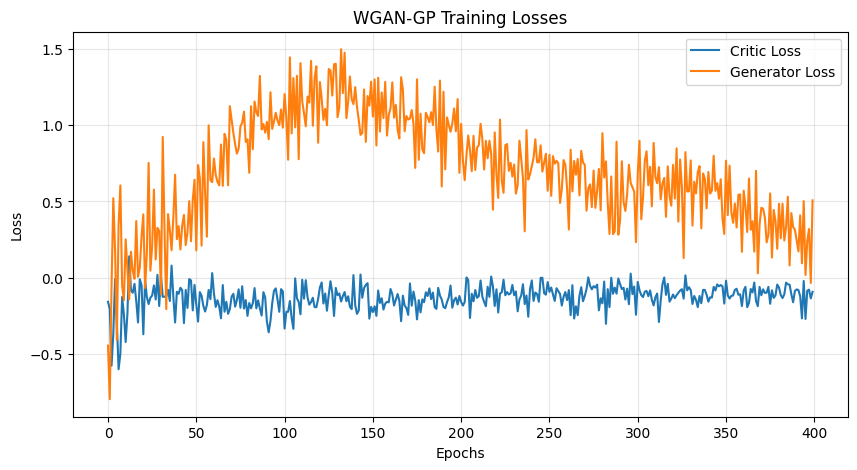

Synthetic data saved to synthetic_fitbit_data.json


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random
import pandas as pd
import json
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = "preprocessed_fitbit_data.csv"
data = pd.read_csv(file_path)

# Extract relevant features
features = [
    "TotalSteps", "TotalDistance", "TrackerDistance", "LoggedActivitiesDistance",
    "VeryActiveDistance", "ModeratelyActiveDistance", "LightActiveDistance",
    "SedentaryActiveDistance", "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "SedentaryMinutes", "Calories", "DayOfWeek", "Month"
]
data_tensor = torch.tensor(data[features].values, dtype=torch.float32)

# Normalize data to [0, 1]
data_min = data_tensor.min(dim=0)[0]
data_max = data_tensor.max(dim=0)[0]
data_tensor = (data_tensor - data_min) / (data_max - data_min)

# Create DataLoader
batch_size = 64
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic (Discriminator in WGAN-GP)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Gradient Penalty Function
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)  # Match the shape of real_data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.clone().detach().requires_grad_(True)  # Create a leaf tensor with requires_grad

    critic_interpolates = critic(interpolates)
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates, device=real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Hyperparameters
noise_dim = 10
data_dim = len(features)
num_epochs = 400  # Ensure this matches your desired epochs
lr = 0.0002
lambda_gp = 10  # Gradient penalty coefficient

# Instantiate models
generator = Generator(noise_dim, data_dim)
critic = Critic(data_dim)

# Optimizers
optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

# Initialize lists to store losses
critic_losses = []
generator_losses = []

# Training Loop
for epoch in range(num_epochs):
    for real_data, in data_loader:
        real_data = real_data.to(generator.model[0].weight.device)  # Ensure data is on the correct device
        batch_size = real_data.size(0)

        # Train Critic
        for _ in range(5):  # Update critic 5 times per generator update
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            real_score = critic(real_data)
            fake_score = critic(fake_data.detach())
            gp = gradient_penalty(critic, real_data, fake_data)
            critic_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator
        noise = torch.randn(batch_size, noise_dim, device=real_data.device)
        fake_data = generator(noise)
        gen_loss = -critic(fake_data).mean()
        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()

    # Log losses once per epoch
    critic_losses.append(critic_loss.item())
    generator_losses.append(gen_loss.item())

    if epoch % 10 == 0:  # Adjust print frequency as needed
        print(f"Epoch [{epoch+1}/{num_epochs}], Critic Loss: {critic_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(critic_losses)), critic_losses, label="Critic Loss")
plt.plot(range(len(generator_losses)), generator_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Losses")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Generate Synthetic Data ---
num_participants = 200
num_days = 31
synthetic_data = []

for participant_id in range(num_participants):
    participant_records = []
    for day in range(num_days):
        noise = torch.randn(1, noise_dim, device=generator.model[0].weight.device)
        generated = generator(noise).detach().cpu().numpy().flatten()
        # Rescale back to original range
        generated = generated * (data_max.numpy() - data_min.numpy()) + data_min.numpy()
        generated = np.clip(generated, 0, None)  # Ensure no negative values
        record = {
            "Id": participant_id + 1,
            "ActivityDate": f"2024-01-{day+1:02d}",
            "TotalSteps": int(generated[0]),
            "TotalDistance": float(generated[1]),
            "TrackerDistance": float(generated[2]),
            "LoggedActivitiesDistance": float(generated[3]),
            "VeryActiveDistance": float(generated[4]),
            "ModeratelyActiveDistance": float(generated[5]),
            "LightActiveDistance": float(generated[6]),
            "SedentaryActiveDistance": float(generated[7]),
            "VeryActiveMinutes": float(generated[8]),
            "FairlyActiveMinutes": float(generated[9]),
            "LightlyActiveMinutes": float(generated[10]),
            "SedentaryMinutes": float(generated[11]),
            "Calories": int(generated[12]),
            "DayOfWeek": int(generated[13] % 7),
            "Month": int(generated[14] % 12 + 1)
        }
        participant_records.append(record)
    synthetic_data.append({f"participant_{participant_id}": participant_records})

# Save to JSON
output_json_path = "synthetic_fitbit_data.json"
with open(output_json_path, "w") as json_file:
    json.dump(synthetic_data, json_file, indent=4)

print(f"Synthetic data saved to {output_json_path}")


Kullback-Leibler Divergence: inf
Jensen-Shannon Divergence: 0.7758
Earth Mover's Distance (EMD): 748.9631

Moments Comparison:
Mean - Original: 7927.1167, Synthetic: 7255.0965
Variance - Original: 27270970.9725, Synthetic: 24400138.1375
Skewness - Original: 0.7435, Synthetic: 0.8622
Kurtosis - Original: 1.4757, Synthetic: 0.9604


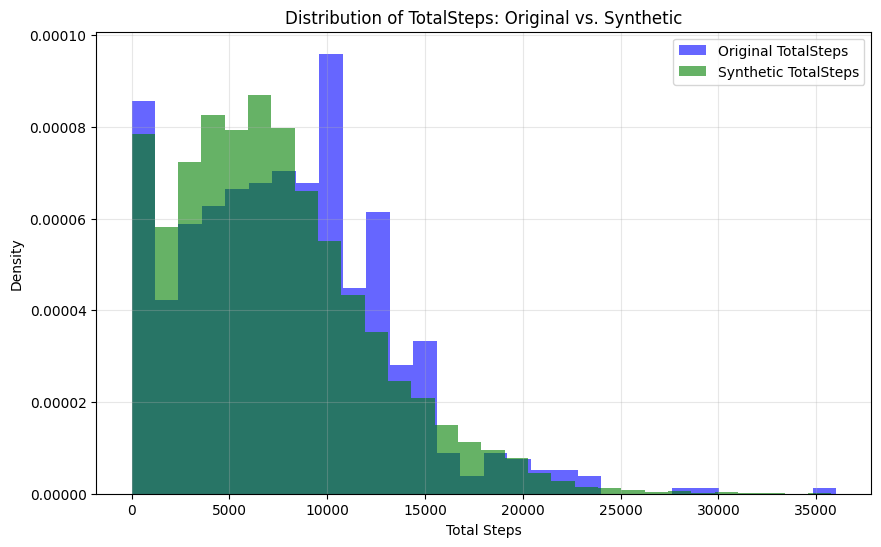

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, chi2_contingency
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence
kl_divergence = entropy(original_counts, synthetic_counts)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")


# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")


# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# --- Visualization ---
plt.figure(figsize=(10, 6))

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Original Data KS Test against Normal Distribution
Statistic: 0.06451020319195282, p-value: 0.008468210054264357

KS Test between Original and Synthetic Data
Statistic: 0.111605222734255, p-value: 7.560658515985675e-07


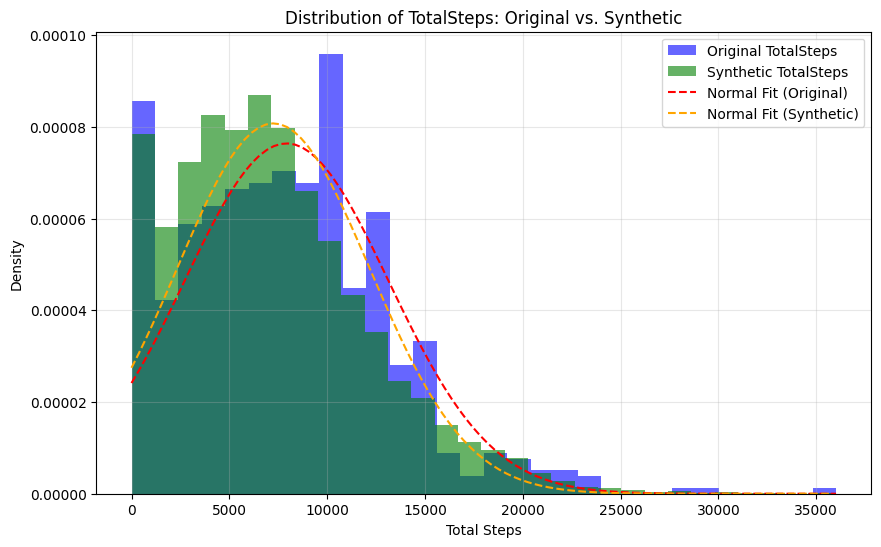

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm
import matplotlib.pyplot as plt
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for both datasets
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# Perform KS Test against a normal distribution (original dataset)
mean_original, std_original = np.mean(original_steps), np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("Original Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic}, p-value: {ks_test_original.pvalue}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic}, p-value: {ks_test_comparison.pvalue}")

# Visualization: Distributions
plt.figure(figsize=(10, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic, std_synthetic = np.mean(synthetic_steps), np.std(synthetic_steps)


# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')


# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


now with some changes to improve statistics

Eval1

Kullback-Leibler Divergence: inf
Jensen-Shannon Divergence: 0.7808
Earth Mover's Distance (EMD): 414.9412

Moments Comparison:
Mean - Original: 7927.1167, Synthetic: 8047.6539
Variance - Original: 27270970.9725, Synthetic: 26720386.3073
Skewness - Original: 0.7435, Synthetic: 0.7641
Kurtosis - Original: 1.4757, Synthetic: 0.6027


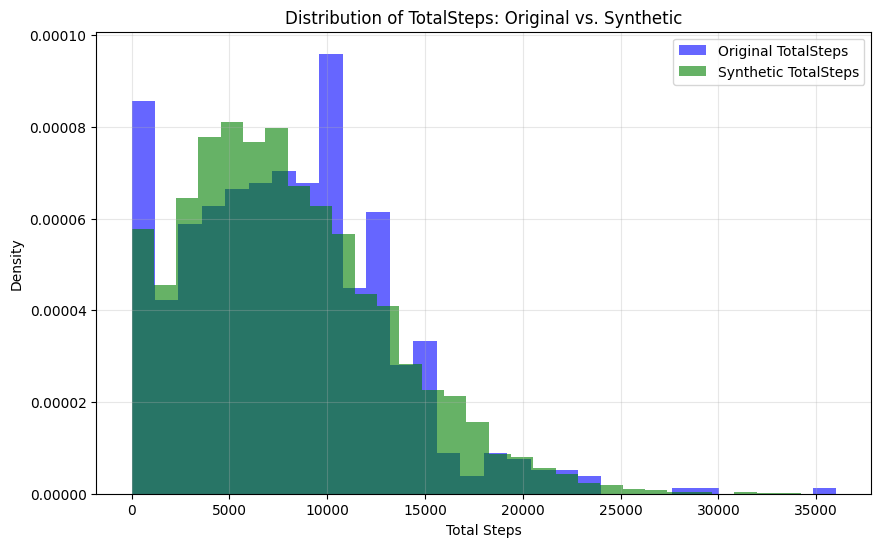

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, chi2_contingency
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence
kl_divergence = entropy(original_counts, synthetic_counts)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")


# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")


# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# --- Visualization ---
plt.figure(figsize=(10, 6))

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Original Data KS Test against Normal Distribution
Statistic: 0.06451020319195282, p-value: 0.008468210054264357

KS Test between Original and Synthetic Data
Statistic: 0.04956989247311828, p-value: 0.10665273316177631


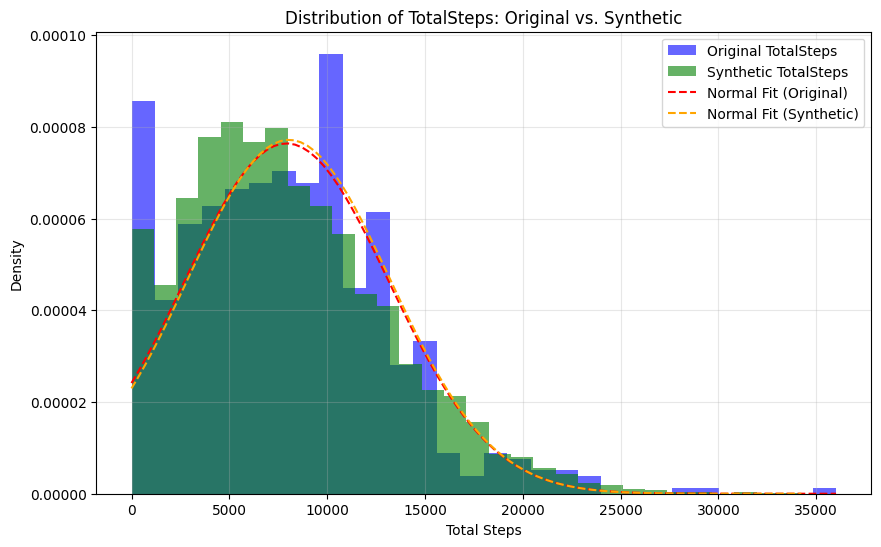

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm
import matplotlib.pyplot as plt
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for both datasets
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# Perform KS Test against a normal distribution (original dataset)
mean_original, std_original = np.mean(original_steps), np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("Original Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic}, p-value: {ks_test_original.pvalue}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic}, p-value: {ks_test_comparison.pvalue}")

# Visualization: Distributions
plt.figure(figsize=(10, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic, std_synthetic = np.mean(synthetic_steps), np.std(synthetic_steps)


# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')


# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Kullback-Leibler Divergence: inf
Jensen-Shannon Divergence: 0.7739
Earth Mover's Distance (EMD): 459.8910

Moments Comparison:
Mean - Original: 7927.1167, Synthetic: 7635.9479
Variance - Original: 27270970.9725, Synthetic: 23192345.6694
Skewness - Original: 0.7435, Synthetic: 0.6397
Kurtosis - Original: 1.4757, Synthetic: 0.3230

Original Data KS Test against Normal Distribution
Statistic: 0.0645, p-value: 0.0085

KS Test between Original and Synthetic Data
Statistic: 0.0682, p-value: 0.0079


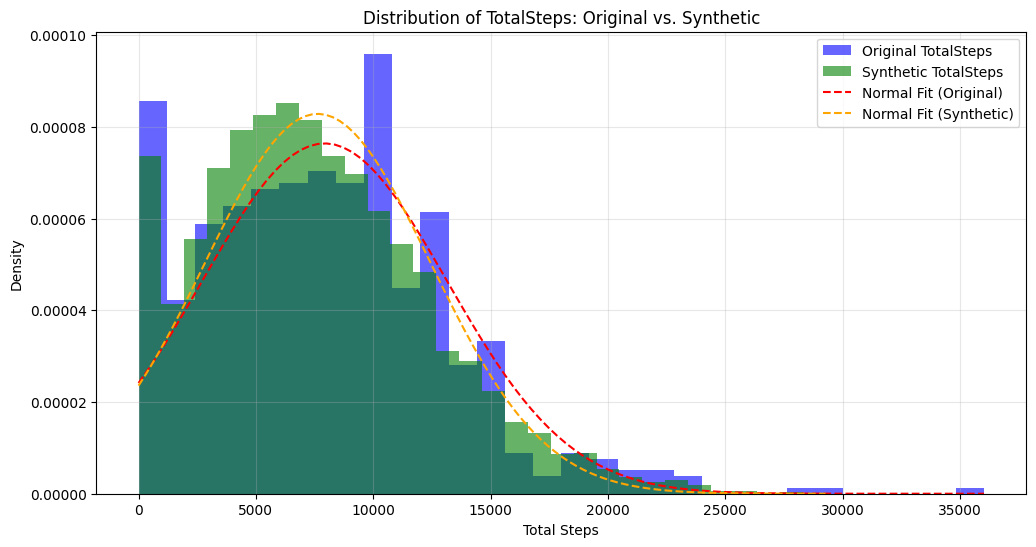

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence
kl_divergence = entropy(original_counts, synthetic_counts)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")

# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# Perform KS Test against a normal distribution (original dataset)
std_original = np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("\nOriginal Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic:.4f}, p-value: {ks_test_original.pvalue:.4f}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic:.4f}, p-value: {ks_test_comparison.pvalue:.4f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation for synthetic data
std_synthetic = np.std(synthetic_steps)

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random
import pandas as pd
import json
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = "preprocessed_fitbit_data.csv"
data = pd.read_csv(file_path)

# Extract relevant features
features = [
    "TotalSteps", "TotalDistance", "TrackerDistance", "LoggedActivitiesDistance",
    "VeryActiveDistance", "ModeratelyActiveDistance", "LightActiveDistance",
    "SedentaryActiveDistance", "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "SedentaryMinutes", "Calories"
]
date_features = ["DayOfWeek", "Month", "ActivityDate"]

data_tensor = torch.tensor(data[features].values, dtype=torch.float32)

# Extract original date-related fields
date_data = data[date_features].drop_duplicates().reset_index(drop=True)
activity_dates = date_data["ActivityDate"].tolist()
day_of_week = date_data["DayOfWeek"].tolist()
month = date_data["Month"].tolist()

# Normalize data to [0, 1]
data_min = data_tensor.min(dim=0)[0]
data_max = data_tensor.max(dim=0)[0]
data_tensor = (data_tensor - data_min) / (data_max - data_min)

# Create DataLoader
batch_size = 128
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic (Discriminator in WGAN-GP)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Gradient Penalty Function
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.clone().detach().requires_grad_(True)

    critic_interpolates = critic(interpolates)
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates, device=real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Hyperparameters
noise_dim = 10
data_dim = len(features)
num_epochs = 400
lr = 0.0002
lambda_gp = 10
critic_updates = 5
generator_updates = 2

# Instantiate models
generator = Generator(noise_dim, data_dim)
critic = Critic(data_dim)

# Optimizers
optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

# Training Loop
for epoch in range(num_epochs):
    for real_data, in data_loader:
        real_data = real_data.to(generator.model[0].weight.device)
        batch_size = real_data.size(0)

        # Train Critic
        for _ in range(critic_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            real_score = critic(real_data)
            fake_score = critic(fake_data.detach())
            gp = gradient_penalty(critic, real_data, fake_data)
            critic_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator
        for _ in range(generator_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            gen_loss = -critic(fake_data).mean()
            optim_gen.zero_grad()
            gen_loss.backward()
            optim_gen.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Critic Loss: {critic_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

# Generate Synthetic Data
num_participants = 200
num_days = len(activity_dates)
synthetic_data = []

for participant_id in range(num_participants):
    participant_records = []
    for i, date in enumerate(activity_dates):
        noise = torch.randn(1, noise_dim, device=generator.model[0].weight.device)
        generated = generator(noise).detach().cpu().numpy().flatten()
        generated = generated * (data_max.numpy() - data_min.numpy()) + data_min.numpy()
        generated = np.clip(generated, 0, None)
        record = {
            "Id": participant_id + 1,
            "ActivityDate": date,
            "TotalSteps": int(generated[0]),
            "TotalDistance": float(generated[1]),
            "TrackerDistance": float(generated[2]),
            "LoggedActivitiesDistance": float(generated[3]),
            "VeryActiveDistance": float(generated[4]),
            "ModeratelyActiveDistance": float(generated[5]),
            "LightActiveDistance": float(generated[6]),
            "SedentaryActiveDistance": float(generated[7]),
            "VeryActiveMinutes": float(generated[8]),
            "FairlyActiveMinutes": float(generated[9]),
            "LightlyActiveMinutes": float(generated[10]),
            "SedentaryMinutes": float(generated[11]),
            "Calories": int(generated[12]),
            "DayOfWeek": day_of_week[i % len(day_of_week)],
            "Month": month[i % len(month)],
        }
        participant_records.append(record)
    synthetic_data.append({f"participant_{participant_id}": participant_records})

# Save to JSON
output_json_path = "improved_synthetic_fitbit_data.json"
with open(output_json_path, "w") as json_file:
    json.dump(synthetic_data, json_file, indent=4)

print(f"Synthetic data saved to {output_json_path}")


Epoch [1/400], Critic Loss: 2.1385, Generator Loss: -0.2223
Epoch [11/400], Critic Loss: 1.0324, Generator Loss: -1.7078
Epoch [21/400], Critic Loss: -1.1181, Generator Loss: 0.8529
Epoch [31/400], Critic Loss: 0.2831, Generator Loss: -1.7020
Epoch [41/400], Critic Loss: -0.3538, Generator Loss: -0.7337
Epoch [51/400], Critic Loss: -0.6227, Generator Loss: -0.4686
Epoch [61/400], Critic Loss: -0.7828, Generator Loss: -0.6515
Epoch [71/400], Critic Loss: -0.3253, Generator Loss: -1.2959
Epoch [81/400], Critic Loss: 0.4786, Generator Loss: -1.4777
Epoch [91/400], Critic Loss: 0.1354, Generator Loss: -0.2947
Epoch [101/400], Critic Loss: 0.0004, Generator Loss: -1.3448
Epoch [111/400], Critic Loss: 0.3950, Generator Loss: -0.5049
Epoch [121/400], Critic Loss: -0.4578, Generator Loss: -0.8825
Epoch [131/400], Critic Loss: 0.3146, Generator Loss: -1.1300
Epoch [141/400], Critic Loss: -0.4736, Generator Loss: -0.5114
Epoch [151/400], Critic Loss: -0.2272, Generator Loss: -0.2369
Epoch [161/4

Eval completa y buena

Kullback-Leibler Divergence: 11.2052
Jensen-Shannon Divergence: 0.7739
Earth Mover's Distance (EMD): 459.8910
R2 Score: -0.8691
Mean Absolute Error (MAE): 5581.6498
Pearson Correlation Coefficient: -0.0415

Moments Comparison:
Mean - Original: 7927.1167, Synthetic: 7346.0538
Variance - Original: 27270970.9725, Synthetic: 21359525.5931
Skewness - Original: 0.7435, Synthetic: 0.6265
Kurtosis - Original: 1.4757, Synthetic: 0.3809

Original Data KS Test against Normal Distribution
Statistic: 0.0645, p-value: 0.0085

KS Test between Original and Synthetic Data
Statistic: 0.0983, p-value: 0.0037


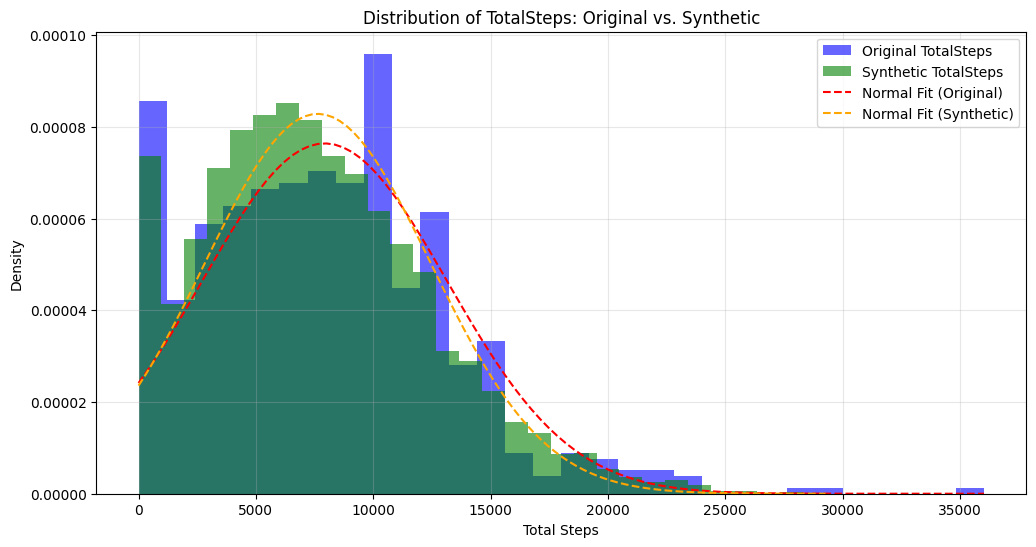

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import random
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']

# Downsample synthetic data to match original data size
random.seed(42)
synthetic_steps_downsampled = synthetic_steps.sample(n=len(original_steps), random_state=42)

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence with smoothing to avoid `inf`
epsilon = 1e-10
kl_divergence = entropy(original_counts + epsilon, synthetic_counts + epsilon)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")

# --- Additional Metrics ---
# R2 Score
r2 = r2_score(original_steps, synthetic_steps_downsampled)
print(f"R2 Score: {r2:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(original_steps, synthetic_steps_downsampled)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(original_steps, synthetic_steps_downsampled)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps_downsampled)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps_downsampled)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps_downsampled.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps_downsampled.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# Perform KS Test against a normal distribution (original dataset)
std_original = np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("\nOriginal Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic:.4f}, p-value: {ks_test_original.pvalue:.4f}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps_downsampled)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic:.4f}, p-value: {ks_test_comparison.pvalue:.4f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic = np.mean(synthetic_steps)
std_synthetic = np.std(synthetic_steps)

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


calories evaluation

Kullback-Leibler Divergence: 6.9332
Jensen-Shannon Divergence: 0.7097
Earth Mover's Distance (EMD): 803.8154
R2 Score: -2.1083
Mean Absolute Error (MAE): 1003.5960
Pearson Correlation Coefficient: -0.0650

Moments Comparison:
Mean - Original: 2304.7097, Synthetic: 1449.4301
Variance - Original: 496540.9280, Synthetic: 267918.5308
Skewness - Original: 0.4779, Synthetic: 0.3122
Kurtosis - Original: 0.1398, Synthetic: 0.9530

Original Data KS Test against Normal Distribution
Statistic: 0.1020, p-value: 0.0000

KS Test between Original and Synthetic Data
Statistic: 0.5668, p-value: 0.0000


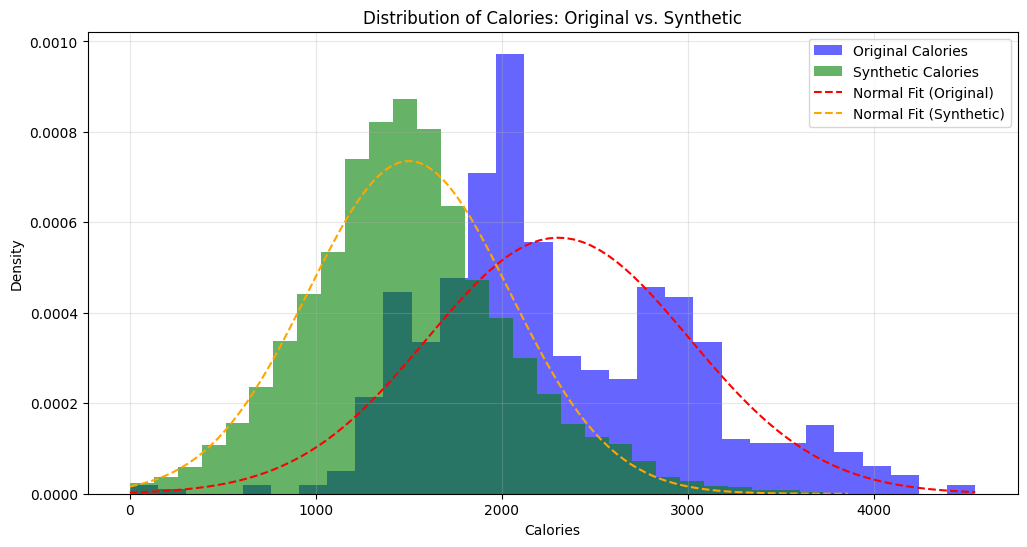

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import random
import json

# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Focus on the 'Calories' column for evaluation
original_calories = original_df['Calories']
synthetic_calories = synthetic_df['Calories']

# Downsample synthetic data to match original data size
random.seed(42)
synthetic_calories_downsampled = synthetic_calories.sample(n=len(original_calories), random_state=42)

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_calories.value_counts(normalize=True)
synthetic_counts = synthetic_calories.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence with smoothing to avoid `inf`
epsilon = 1e-10
kl_divergence = entropy(original_counts + epsilon, synthetic_counts + epsilon)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_calories, synthetic_calories)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")

# --- Additional Metrics ---
# R2 Score
r2 = r2_score(original_calories, synthetic_calories_downsampled)
print(f"R2 Score: {r2:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(original_calories, synthetic_calories_downsampled)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(original_calories, synthetic_calories_downsampled)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_calories), np.mean(synthetic_calories_downsampled)
variance_original, variance_synthetic = np.var(original_calories), np.var(synthetic_calories_downsampled)
skewness_original, skewness_synthetic = original_calories.skew(), synthetic_calories_downsampled.skew()
kurtosis_original, kurtosis_synthetic = original_calories.kurtosis(), synthetic_calories_downsampled.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# Perform KS Test against a normal distribution (original dataset)
std_original = np.std(original_calories)
ks_test_original = kstest(original_calories, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("\nOriginal Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic:.4f}, p-value: {ks_test_original.pvalue:.4f}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_calories, synthetic_calories_downsampled)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic:.4f}, p-value: {ks_test_comparison.pvalue:.4f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic = np.mean(synthetic_calories)
std_synthetic = np.std(synthetic_calories)

# Plot Original Distribution
plt.hist(original_calories, bins=30, density=True, alpha=0.6, label='Original Calories', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_calories, bins=30, density=True, alpha=0.6, label='Synthetic Calories', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_calories), max(original_calories), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_calories), max(synthetic_calories), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')

# Add Labels and Legend
plt.title('Distribution of Calories: Original vs. Synthetic')
plt.xlabel('Calories')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


overall

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy, wasserstein_distance, pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr
import matplotlib.pyplot as plt
import random
import json

# Load original data
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Ensure matching columns between original and synthetic data
common_columns = list(set(original_df.columns) & set(synthetic_df.columns))
original_df = original_df[common_columns]
synthetic_df = synthetic_df[common_columns]

# Downsample synthetic data to match the size of the original dataset
synthetic_df_downsampled = synthetic_df.sample(n=len(original_df), random_state=42)

# Define metrics for evaluation
metrics = {
    'Variable': [],
    'EMD': [],
    'MAE': [],
    'R2': [],
    'KL Divergence': [],
    'JS Divergence': [],
    'Pearson Correlation': []
}

# Evaluate metrics for each variable
epsilon = 1e-10
for column in common_columns:
    if column == 'Participant' or original_df[column].dtype == object:
        continue  # Skip non-numeric columns

    # Extract data for the current variable
    original_values = original_df[column].values
    synthetic_values = synthetic_df_downsampled[column].values

    # Compute metrics
    emd = wasserstein_distance(original_values, synthetic_values)
    mae = mean_absolute_error(original_values, synthetic_values)
    r2 = r2_score(original_values, synthetic_values)

    # Compute distribution-based metrics
    original_dist = pd.Series(original_values).value_counts(normalize=True).reindex(
        np.arange(min(original_values), max(original_values) + 1), fill_value=0
    )
    synthetic_dist = pd.Series(synthetic_values).value_counts(normalize=True).reindex(
        np.arange(min(original_values), max(original_values) + 1), fill_value=0
    )

    kl_divergence = entropy(original_dist + epsilon, synthetic_dist + epsilon)
    js_divergence = jensenshannon(original_dist + epsilon, synthetic_dist + epsilon)
    pearson_corr, _ = pearsonr(original_values, synthetic_values)

    # Append metrics to results
    metrics['Variable'].append(column)
    metrics['EMD'].append(emd)
    metrics['MAE'].append(mae)
    metrics['R2'].append(r2)
    metrics['KL Divergence'].append(kl_divergence)
    metrics['JS Divergence'].append(js_divergence)
    metrics['Pearson Correlation'].append(pearson_corr)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Calculate overall evaluation
overall_metrics = {
    'Average EMD': metrics_df['EMD'].mean(),
    'Average MAE': metrics_df['MAE'].mean(),
    'Average R2': metrics_df['R2'].mean(),
    'Average KL Divergence': metrics_df['KL Divergence'].mean(),
    'Average JS Divergence': metrics_df['JS Divergence'].mean(),
    'Average Pearson Correlation': metrics_df['Pearson Correlation'].mean()
}

# Display results
print("Per-Variable Metrics:")
print(metrics_df)

print("\nOverall Metrics:")
for metric, value in overall_metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
metrics_df.set_index('Variable').plot(kind='bar', figsize=(15, 8), alpha=0.7)
plt.title("Metrics per Variable")
plt.xlabel("Variables")
plt.ylabel("Metric Value")
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.show()
